In [1]:
"""This code was written by
        Eva Batelaan <batelaan@stanford.edu>
        Thomas Brink <tbrink@stanford.edu>
        Michelle Lahrkamp <ml17270@stanford.edu>
    Assignment 2 Group 3

    Parses through collected tweets, replies, and reply mappings to build reply
    trees and reply graphs.

    Use:
    python3 create_reply_tree.py

    The following flags are required:
        --initial_tweets: txt of output generated by download_tweets.py
            ex: congress_df_YYYY-MM-DD_tweets.txt
        --reply_tweets: txt of output generated by download_reply_tweets.py
            ex: congress_df_YYYY-MM-DD_reply_tweets.txt
        --reply_mappings: txt of output generated by get_reply_id.py
            ex: congress_df_YYYY-MM-DD_reply_mappings.txt

    Note:
    YYYY-MM-DD should match the YYYY-MM-DD in the name of the reply_tweets file
"""
import argparse
from array import array
import json
import ast
import sys
import numpy as np
import networkx
import traceback
from treelib import Node, Tree


def eprint(*args, **kwargs):
    """Print to stderr
    """
    print(*args, file=sys.stderr, **kwargs)


def create_tweet_tree(tweet: json, cid_tree_dict: dict):
    """Create a reply tree with the original tweet as the root note.
    """
    tweet_info = tweet['tweet_info']
    cid = tweet_info['conversation_id']
    tweet_id = tweet_info['id']
    if cid == tweet_id: # Only make a tree once we've found the original tweet
        tree = Tree()
        tweet_info['public_metrics']['dropped_node_count'] = 0
        tweet_info['public_metrics']['author_id'] = tweet_info['author_id']
        tree.create_node(tweet_id, tweet_id, data=tweet_info['public_metrics'])
        cid_tree_dict[cid] = tree


def create_tweet_graph(tweet: json, cid_graph_dict: dict):
    """Create a user graph with the original tweet's author as the inital node.
    """
    tweet_info = tweet['tweet_info']
    cid = tweet_info['conversation_id']
    tweet_id = tweet_info['id']
    if cid == tweet_id: # Only make a graph once we've found the original tweet
        graph = networkx.DiGraph(dropped_edge_count=0, dropped_node_count=0)
        graph.add_node(tweet_info['author_id'],
                       public_metrics=tweet['user_info']['public_metrics'])
        cid_graph_dict[cid] = graph


def create_tweet_tree_node(tweet: json, cid_tree_dict: dict):
    """Add a node for the tweet to the conversation's tweet tree with the root
       node as the default parent.
    """
    tweet_info = tweet['tweet_info']
    cid = tweet_info['conversation_id']
    if cid not in cid_tree_dict.keys():
        pass # Reply tweet with no matching cid (original tweet not available)
    else:
        tree = cid_tree_dict[cid]
        nid = tweet_info['id']
        if nid not in tree.nodes: # Some tweets have the same id
            try:
                tree.create_node(nid, nid, parent=tree.root)
            except:
                tree[tree.root].data['dropped_node_count'] += 1


def create_tweet_graph_node(tweet: json, cid_graph_dict: dict, reply_user_mappings: dict):
    """Add a node for the reply tweet author to the conversation's user graph.
    """
    tweet_info = tweet['tweet_info']
    cid = tweet_info['conversation_id']
    if cid not in cid_graph_dict.keys():
        pass # Reply tweet with no matching cid (original tweet not available)
    else:
        graph = cid_graph_dict[cid]
        author_id = tweet_info['author_id']
        if author_id not in graph.nodes:
            try:
                d = ast.literal_eval(reply_user_mappings[str(tweet_info['id'])])
                graph.add_node(author_id,
                           public_metrics=d['public_metrics'])
            except:
                # User information could not be pulled for node
                graph.graph['dropped_node_count'] += 1


def create_tweet_graph_edge(tweet: json, cid_graph_dict: dict):
    """Add edge from the author_id to the id of the user to whom they tweet
       is replying to the conversation's user graph.
    """
    tweet_info = tweet['tweet_info']
    cid = tweet_info['conversation_id']
    if cid not in cid_graph_dict.keys():
        pass # Reply tweet with no matching cid (original tweet not available)
    else:
        graph = cid_graph_dict[cid]
        author_id = tweet_info['author_id']
        in_reply_to = tweet_info['in_reply_to_user_id']
        if (author_id, in_reply_to) not in graph.edges:
            try:
                graph.add_edge(author_id, in_reply_to)
            except:
                # One of the nodes could not be added
                graph.graph['dropped_edge_count'] += 1


def reorder_trees(cid_tree_dict: dict, reply_mappings: dict):
    """Once all nodes have been added, connect the nodes to the correct parent
       using the reply to mappings.
    """
    for cid, tree in cid_tree_dict.items():
        for node in tree.all_nodes():
            if node.is_root():
                continue  # don't drop the root node
            nid = node.identifier
            try: 
                parent_nid = reply_mappings.get(nid)
                tree.move_node(nid, parent_nid)
            except:
                drop_node(nid, tree)

def drop_node(nid: str, tree: Tree):
    nodes_dropped = len(tree.subtree(nid).nodes)
    tree[tree.root].data['dropped_node_count'] += nodes_dropped
    tree.remove_node(nid)

def create_reply_trees_and_graphs(reply_tweets, initial_tweets, reply_mappings):
    """Parse through the collected data and build the reply trees
       and user graphs.
    """
    # Extract cids for which we got replies.
    reply_cids = set()
    for line in open(reply_tweets, 'r', encoding='utf-8'):
        tweet = json.loads(line)
        reply_cids.add(tweet['tweet_info']['conversation_id'])
    
    eprint('Number of reply cids found: {}'.format(len(reply_cids)))

    # Make trees and graphs.
    cid_tree_dict = {}
    cid_graph_dict = {}
    prob_sample = 0.3 
    for line in open(initial_tweets, 'r', encoding='utf-8'):
        tweet = json.loads(line)
        cid = tweet['tweet_info']['conversation_id']
        reply_count = tweet['tweet_info']['public_metrics']['reply_count']
        # Only include conversations for which we retrieved replies
        # and randomly select conversations with no replies.
        if cid in reply_cids or (reply_count == 0 and np.random.uniform() < prob_sample):
            create_tweet_tree(tweet, cid_tree_dict)
            create_tweet_graph(tweet, cid_graph_dict)
    
    eprint('Length of cid_tree_dict: {}, length of cid_graph_dict: {}'
           .format(len(cid_tree_dict), len(cid_graph_dict)))

    # Build dictionary of tweet ids to which reply tweets are replying
    reply_to_mappings = {}
    # Build dictionary of user info of reply tweets
    reply_user_mappings = {}
    for line in open(reply_mappings, 'r', encoding='utf-8'):
        data = ast.literal_eval(line)
        reply_to_mappings[str(data['id'])] = str(data['replied_to_tweet_id'])
        reply_user_mappings[str(data['id'])] = str(data['user_info'])
        
    eprint('Built mapping dictionaries.')
    
    # Add replies that were pulled when pulling original conversations
    for line in open(initial_tweets, 'r', encoding='utf-8'):
        tweet = json.loads(line)
        tweet_info = tweet['tweet_info']
        if tweet_info['id'] != tweet_info['conversation_id']:
            create_tweet_tree_node(tweet, cid_tree_dict)
            create_tweet_graph_node(tweet, cid_graph_dict, reply_user_mappings)

    # Add reply tweets to reply trees and user graphs
    for line in open(reply_tweets, 'r', encoding='utf-8'):
        tweet = json.loads(line)
        create_tweet_tree_node(tweet, cid_tree_dict)
        create_tweet_graph_node(tweet, cid_graph_dict, reply_user_mappings)
        
    eprint('Added nodes to trees and graphs.')

    # Reassign parents in reply tweets using reply mappings
    reorder_trees(cid_tree_dict, reply_to_mappings)
    
    eprint('Rerordered trees.')

    # Add edges to user graph
    for line in open(reply_tweets, 'r', encoding='utf-8'):
        tweet = json.loads(line)
        create_tweet_graph_edge(tweet, cid_graph_dict)
        
    eprint('Added graph edges.')
    
    return cid_tree_dict, cid_graph_dict

In [2]:
from argparse import Namespace

flags = Namespace(initial_tweets='congress_df_2022-10-26_tweets.txt',
                  reply_tweets='congress_df_2022-10-26_reply_tweets.txt',
                  reply_mappings='congress_df_2022-10-26_reply_mappings.txt'
                  )

In [3]:
cid_tree_dict, cid_graph_dict = create_reply_trees_and_graphs(
        flags.reply_tweets, flags.initial_tweets, flags.reply_mappings
    )

Number of reply cids found: 1439
Length of cid_tree_dict: 1610, length of cid_graph_dict: 1610
Built mapping dictionaries.
Added nodes to trees and graphs.
Rerordered trees.
Added graph edges.


In [4]:
import codecs

def to_graphviz(tree, filename, shape='circle', graph='digraph'):
    """Exports the tree in the dot format of the graphviz software"""
    nodes, connections = [], []
    if tree.nodes:

        for n in tree.expand_tree(mode=tree.WIDTH):
            nid = tree[n].identifier
            state = '"{0}" [label="", shape={1}, width="0.05", penwidth="0.1", style="filled", fillcolor="#1f77b4"]'.format(
                nid, shape)
            nodes.append(state)

            for c in tree.children(nid):
                cid = c.identifier
                connections.append('"{0}" -> "{1}" [arrowsize="0.1", penwidth="0.1"]'.format(nid, cid))

    # write nodes and connections to dot format
    is_plain_file = filename is not None
    if is_plain_file:
        f = codecs.open(filename, 'w', 'utf-8')
    else:
        f = StringIO()

    f.write(graph + ' tree {\n')
    f.write('\tgraph [nodesep="0.04", ranksep="0.02"]\n')
    for n in nodes:
        f.write('\t' + n + '\n')

    if len(connections) > 0:
        f.write('\n')

    for c in connections:
        f.write('\t' + c + '\n')

    f.write('}')

    if not is_plain_file:
        print(f.getvalue())

In [5]:
def create_reply_tree_viz(cid_tree_dict, filename='reply_tree_viz'):
    """ Function that creates a visualization for a reply tree given some arguments.
    """
    for cid, tree in cid_tree_dict.items():
        if tree.depth() > 10 and tree.size() < 150:
            to_graphviz(tree, filename + '.dot')
            s = Source.from_file(filename + '.dot')
            s.view(filename)
            break

In [26]:
def create_reply_graph_viz(cid_graph_dict, filename='reply_graph_viz.pdf'):
    """ Function that visualizes a reply graph given some arguments.
    """
    for cid, graph in cid_graph_dict.items():
        if graph.size() > 25 and graph.size() < 50:
            plt.figure(1)
            pos = networkx.spring_layout(graph)
            sorted_nodes = sorted(graph.nodes(), key=lambda node: graph.nodes[node]['public_metrics']['followers_count'])
            nodes = networkx.draw_networkx_nodes(
                graph,
                pos,
                nodelist=sorted_nodes,
                node_size=100,
                node_color=range(graph.number_of_nodes()),
                cmap=plt.cm.Blues
            )
            nodes.set_edgecolor('black')
            networkx.draw_networkx_edges(graph, pos, node_size=100)
            plt.savefig(filename)
            break

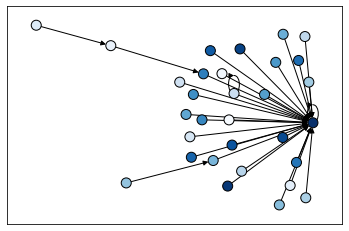

In [28]:
import matplotlib.pyplot as plt
from graphviz import Source

#create_reply_tree_viz(cid_tree_dict)
create_reply_graph_viz(cid_graph_dict)